# Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
# Drive Storage
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Clean and Format Dataframe


In [3]:
# Read csv into DF
df = pd.read_csv('/content/drive/MyDrive/Diabetes/JuanmaCerme_glucose_9-1-2021.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Format DataFrame

# Set index
df1 = pd.DataFrame(list(df.index))
df1.columns = df1.iloc[0]
df1 = df1.drop(index=0)

df1 = df1[df1['Dispositivo'] == 'FreeStyle LibreLink'] # Obtain data from FreeStyle device only
time = pd.to_datetime(df1['Sello de tiempo del dispositivo']) # Time format
time.name = '' # Drop time name index
df1 = df1.set_index(time) # Set time as an index for time series config of DataFrame
df1 = df1.sort_index()

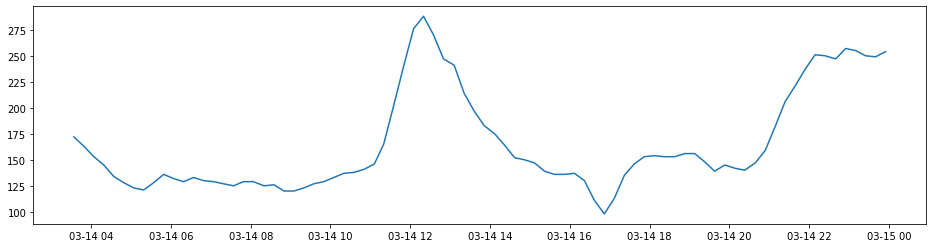

In [5]:
# Plot example 1 day Blood Glucose Level
plt.figure(figsize=(16,4))
plt.plot(df1['Historial de glucosa mg/dL'][200:296].dropna().astype("float"))

# Plots per day

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


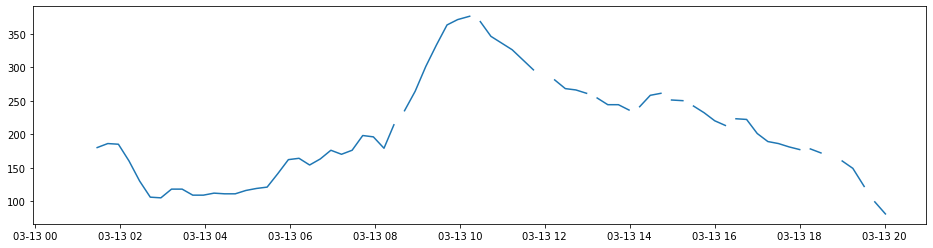

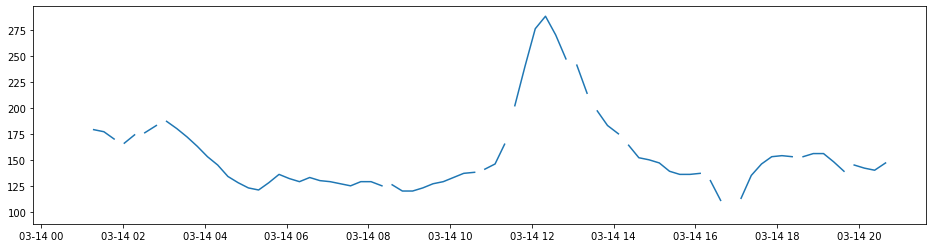

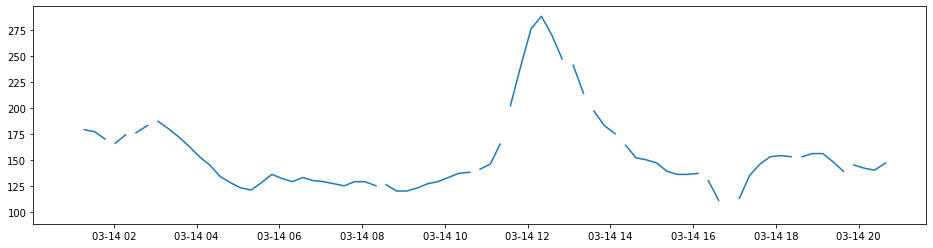

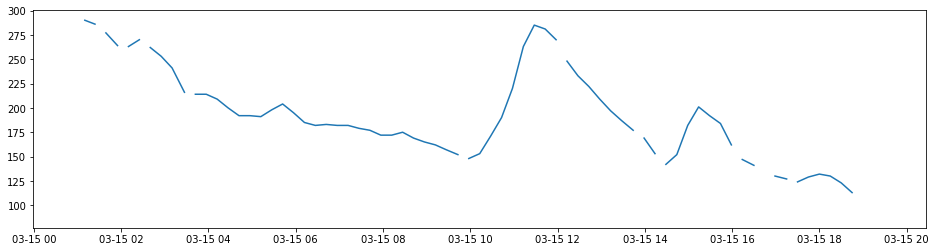

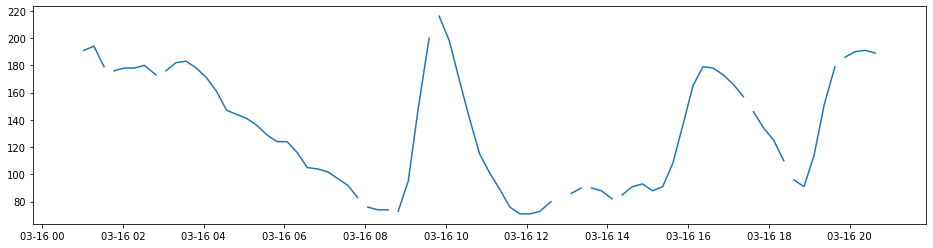

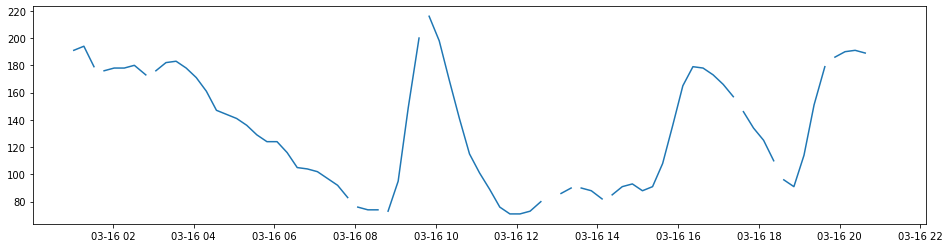

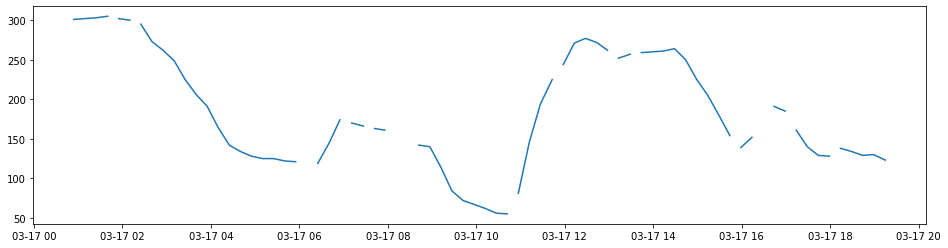

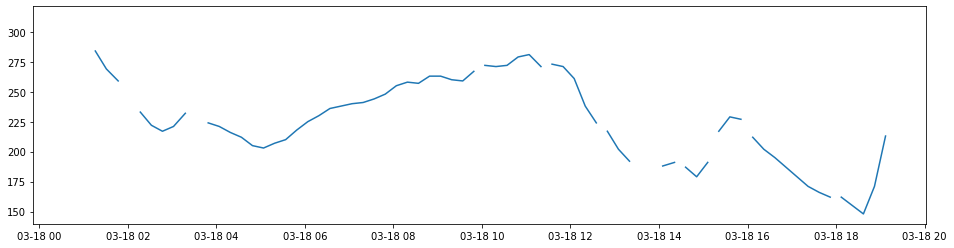

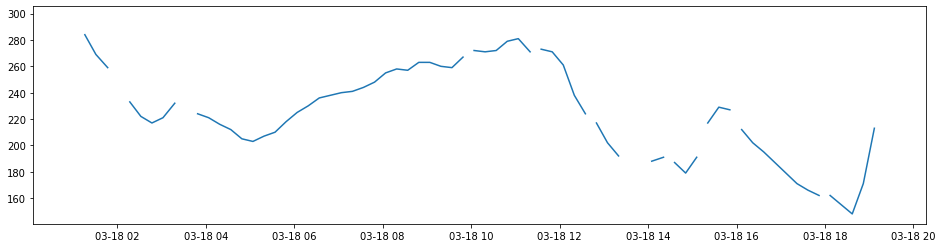

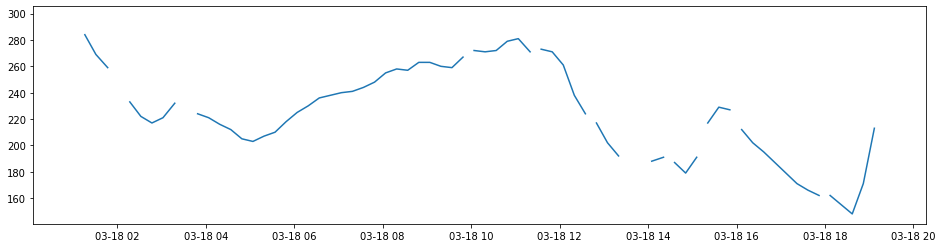

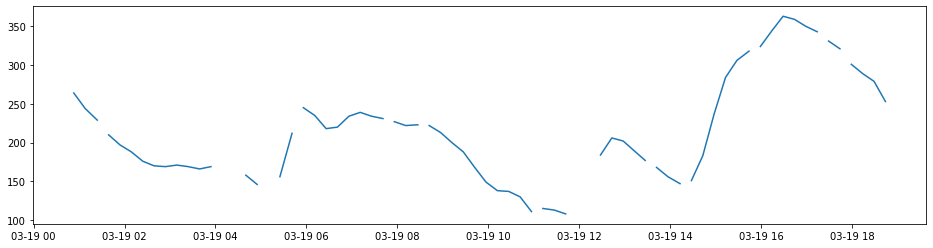

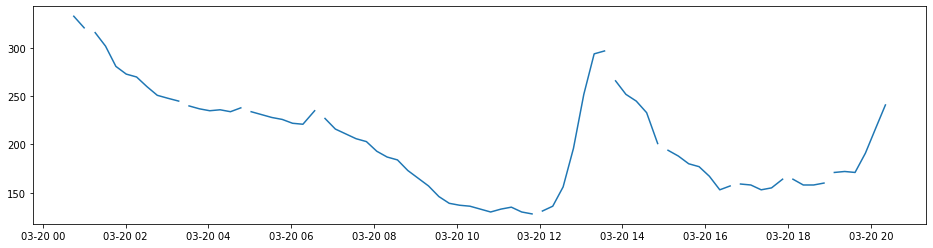

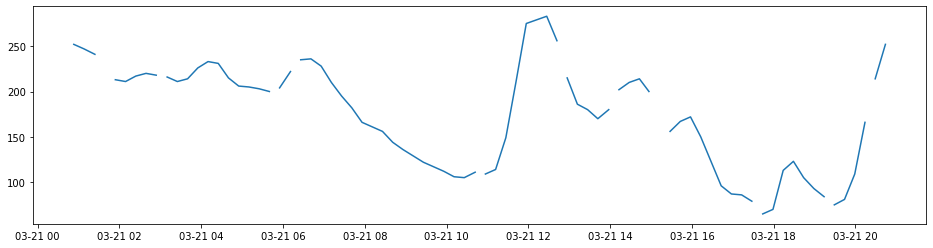

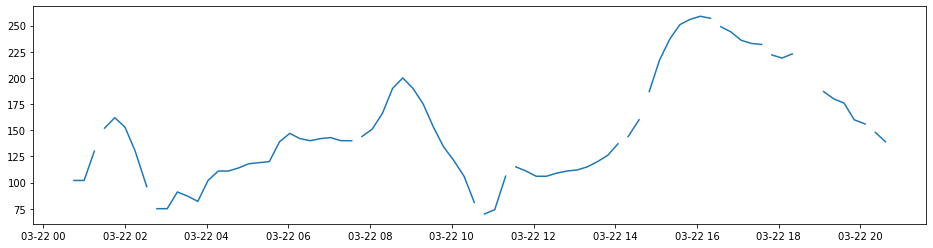

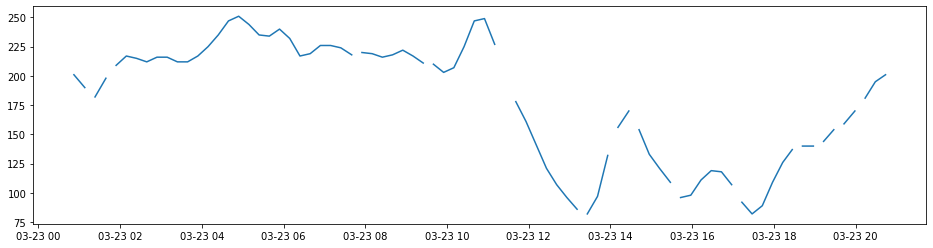

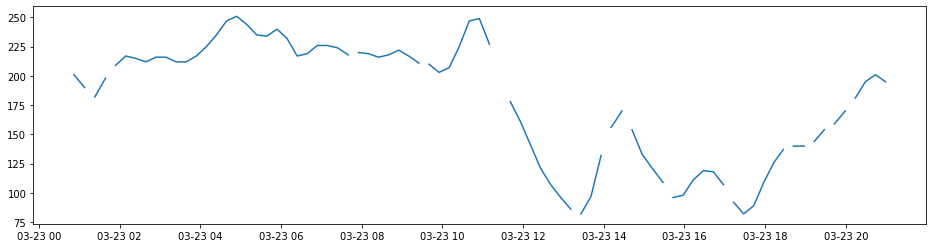

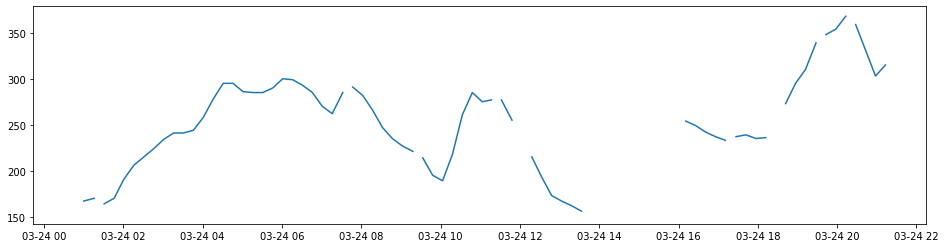

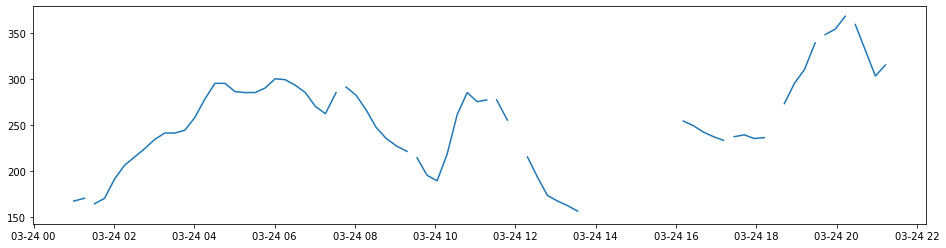

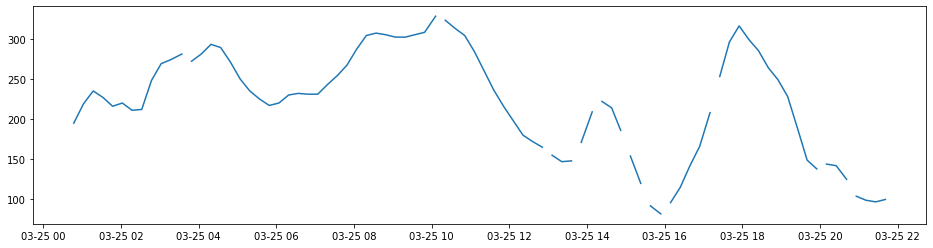

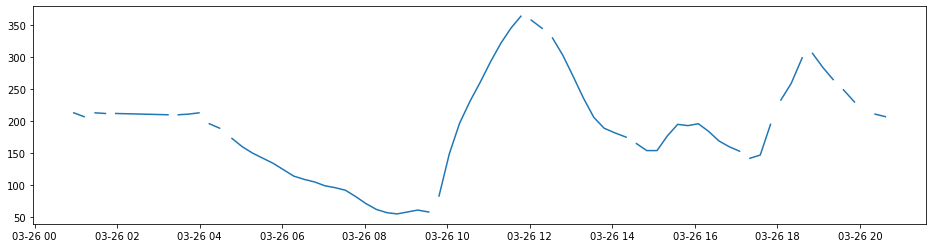

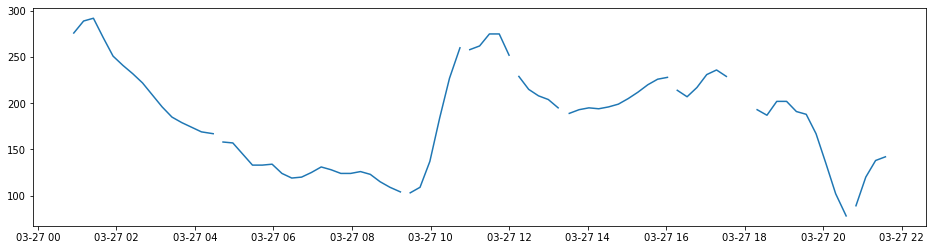

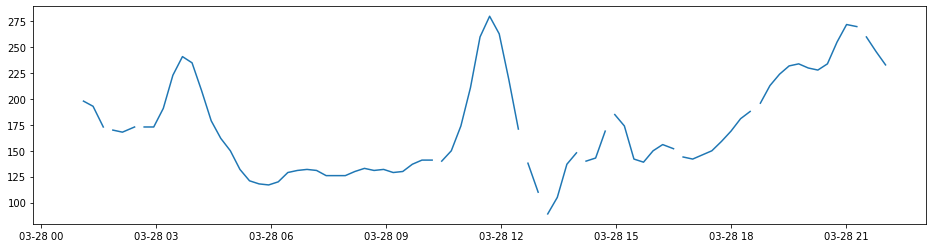

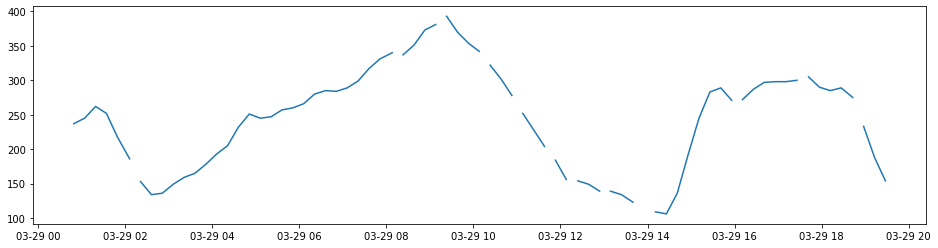

In [7]:
# Plot per day
time_gluc_df = df1['Historial de glucosa mg/dL'].astype("float")
ind = 0
for i in time_gluc_df.index:
  if i.hour == 0 and i.minute >= 45:
    plt.figure(figsize=(16,4))
    plt.plot(time_gluc_df[ind:ind+97])
  ind = ind + 1
  if ind > 2000:
    break

# Plot Means and Quantiles by Weeks/Months

Datos mostrados desde:  2021-08-23  hasta:  2021-09-01


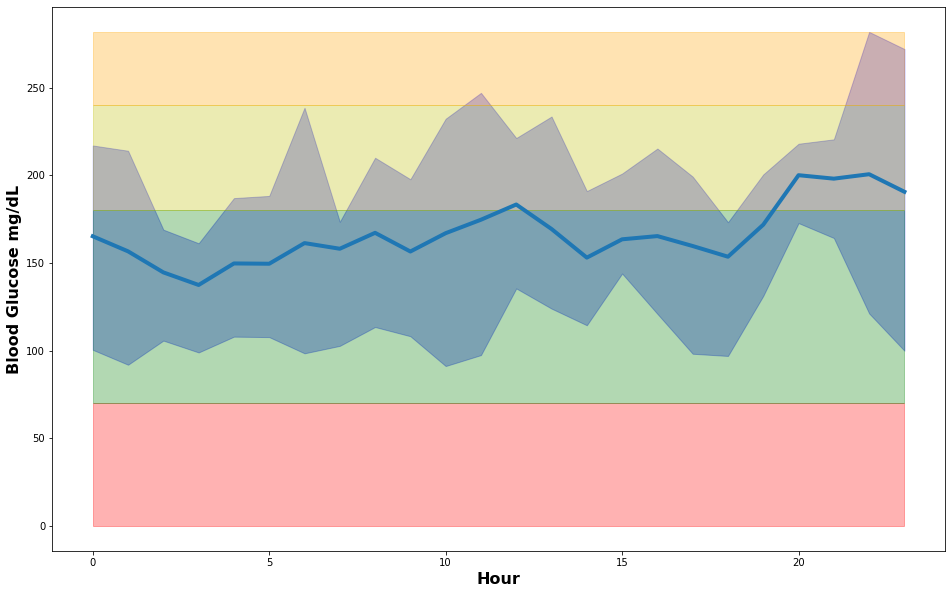

In [11]:
# Compute and Plot Quantile
data_perc = df1['Historial de glucosa mg/dL'].astype("float")[137694  - (96*15):]
res = data_perc.resample('15min').mean()
x = res.groupby(res.index.hour).quantile(.75).index
start = min(data_perc.index)
end = max(data_perc.index)

# Print Date Interval of Data Shown in Plot
# res2 = data_perc.groupby(data_perc.index.hour).mean() # Otra manera de llegar al mismo resultado
print( 'Datos mostrados desde: ',  start.date(), ' hasta: ' ,end.date())

# Plot Data
plt.figure(figsize = (16,10))

plt.fill_between(x , res.groupby(res.index.hour).quantile(.75), res.groupby(res.index.hour).quantile(.25), color= 'b', alpha=.3)
plt.fill_between(x , 70, 0, color= 'r', alpha=.3)
plt.fill_between(x , 70, 180, color= 'g', alpha=.3)
plt.fill_between(x , 240, 180, color= 'y', alpha=.3)
plt.fill_between(x , 240, max(res.groupby(res.index.hour).quantile(.75)), color= 'orange', alpha=.3)
plt.plot(res.groupby(res.index.hour).mean(),linewidth = 4)

plt.xlabel('Hour',fontweight ='bold',fontsize = 16)
plt.ylabel('Blood Glucose mg/dL',fontweight ='bold',fontsize = 16)
plt.show()

# Forecast

In [15]:
# Normalize Data
scaler = StandardScaler() 
#data_perc = df1['Historial de glucosa mg/dL'].astype("float")
data_scaler = pd.DataFrame(data_perc)
data_scaler = pd.DataFrame(scaler.fit_transform(data_scaler), index= data_perc.index)

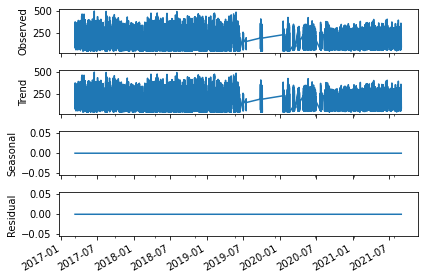

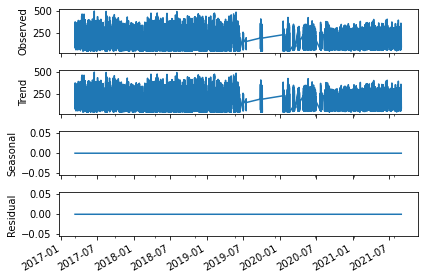

In [33]:
# Forecast previous Study
seasonal_decompose(df1['Historial de glucosa mg/dL'].astype("float").dropna(),freq=1).plot()

In [17]:
res = data_perc.resample('15min').mean()

In [18]:
# Fix alpha Value
alpha = 0.3

# Use of 'SimpleExpSmoothing'
ses_result = SimpleExpSmoothing(res.dropna().iloc[400:]).fit(smoothing_level=alpha)
ses_forecast = ses_result.forecast(50).rename("Simple exp. smoothing (SES)")

# Use of 'ExponentialSmoothing'
# Notese que que a continuacion marcamos 'trend=None, seasonal=None', esto es lo que hace que el ExponentialSmoothing actue como un suavizado exponencial simple
es_result = ExponentialSmoothing(res.dropna().iloc[400:], trend=None, seasonal=None).fit(smoothing_level=alpha)
es_forecast = es_result.forecast(50).rename("Simple exp. smoothing (ES)")

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


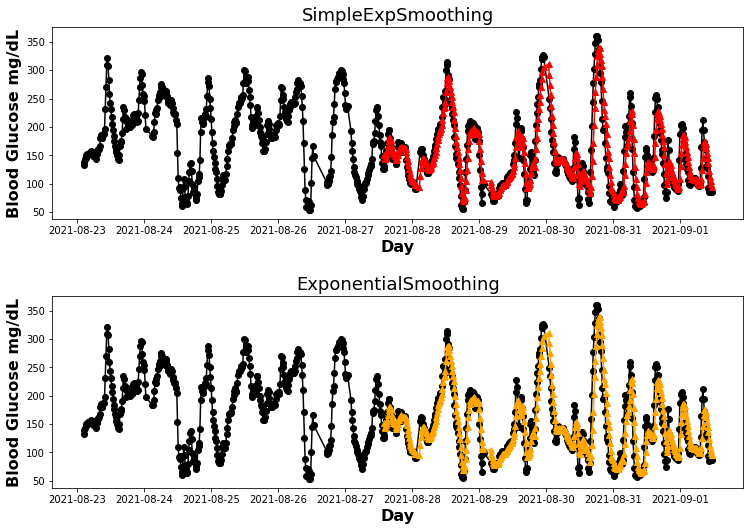

In [46]:
# Brief Forecasting

# First Plot 'SimpleExpSmoothing'
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(data_perc.dropna(), marker='o', color='black')
plt.plot(ses_result.fittedvalues, marker='^', color='red')

plt.xlabel('Day',fontweight ='bold',fontsize = 16)
plt.ylabel('Blood Glucose mg/dL',fontweight ='bold',fontsize = 16)
plt.title('SimpleExpSmoothing',fontsize = 18)

plt.subplot(2, 1, 2)
plt.plot(data_perc.dropna(), marker='o', color='black')
plt.plot(es_result.fittedvalues, marker='^', color='orange')

plt.xlabel('Day',fontweight ='bold',fontsize = 16)
plt.ylabel('Blood Glucose mg/dL',fontweight ='bold',fontsize = 16)
plt.title('ExponentialSmoothing',fontsize = 18)

# Set spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

# Confidence Interval

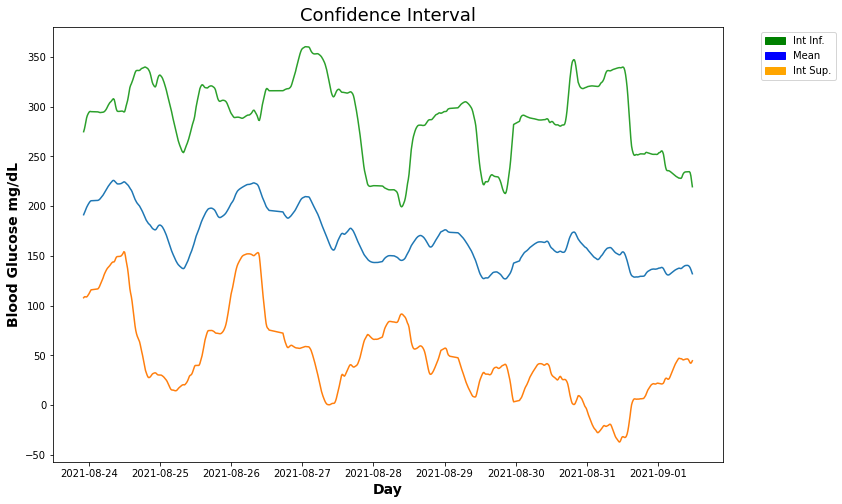

In [47]:
# Confidence Interval
import matplotlib.patches as mpatches

stds = data_perc.dropna().rolling(80)
desv_inf =stds.mean() - ( 2 * stds.std())
desv_sup =stds.mean() + ( 2 * stds.std())

plt.figure(figsize = (12,8))
plt.plot(stds.mean(), )
plt.plot(desv_inf)
plt.plot(desv_sup)

orange_patch = mpatches.Patch(color='orange', label='Int Sup.')
green_patch = mpatches.Patch(color='green', label='Int Inf.')
blue_patch = mpatches.Patch(color='blue', label='Mean')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',prop={'size': 10}, handles=[ green_patch, blue_patch, orange_patch])

plt.xlabel('Day',fontweight ='bold',fontsize = 14)
plt.ylabel('Blood Glucose mg/dL',fontweight ='bold',fontsize = 14)
plt.title('Confidence Interval',fontsize = 18)

plt.show()